In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [4]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

In [5]:
from xgboost import XGBClassifier

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [7]:
pd.set_option('display.max_columns', None)

### Retrieving the data

#### DF 5

In [8]:
df5 = pd.read_csv('df5.csv')

In [9]:
df5.head(2)

,Unnamed: 0,account_balance,duration,credit_history,purpose,credit_amount,savings_bond_value,employed_since,intallment_rate,sex_marital,guarantor,residence_since,property,age,other_installment_plans,type_of_housing,nr_of_existing_credits,job,number_of_dependents,telephone,foreign,target
0,0,0,0,4,4,1,4,4,3,2,0,3,0,9,2,1,1,2,0,1,0,1
1,1,1,7,2,4,8,0,2,1,1,0,1,0,0,2,1,0,2,0,0,0,2


#### DF 5c

In [10]:
df5c = pd.read_csv('df5c.csv')

In [11]:
df5c.head(2)

,Unnamed: 0,account_balance,duration,credit_history,purpose,credit_amount,savings_bond_value,employed_since,intallment_rate,sex_marital,guarantor,residence_since,property,age,other_installment_plans,type_of_housing,nr_of_existing_credits,job,number_of_dependents,telephone,foreign,target
0,0,0,6,4,4,1169,4,4,4,2,0,4,0,67,2,1,2,2,1,1,0,1
1,1,1,48,2,4,5951,0,2,2,1,0,2,0,22,2,1,1,2,1,0,0,2


# Models

In [12]:
# Initialize lists to store evaluation metrics for each fold
dataset_used = []
model_used = []
data_balancing_technique = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

In [13]:
#combined_metrics = pd.DataFrame()

combined_metrics = pd.DataFrame(columns=['dataset', 'model', 'data balancing technique', 'fold', 'precision_1','precision_2','recall_1','recall_2','f1-score_1','f1-score_2','support_1','support_2','TP','FP','TN','FN'])

# XGBClassifier

## DF5

In [14]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'None',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.75
Mean Precision: 0.75
Mean Recall: 0.75
Mean F1-Score: 0.74


In [15]:
combined_metrics[(combined_metrics['data balancing technique'] == 'None') & (combined_metrics['dataset'] == 'DF5')]#.head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
0,DF5,XGBClassifier,None,1,0.867647,0.625000,0.830986,0.689655,0.848921,0.655738,71.0,29.0,59,9,20,12
1,DF5,XGBClassifier,None,2,0.807692,0.681818,0.900000,0.500000,0.851351,0.576923,70.0,30.0,63,15,15,7
2,DF5,XGBClassifier,None,3,0.746835,0.571429,0.867647,0.375000,0.802721,0.452830,68.0,32.0,59,20,12,9
3,DF5,XGBClassifier,None,4,0.809524,0.687500,0.931507,0.407407,0.866242,0.511628,73.0,27.0,68,16,11,5
4,DF5,XGBClassifier,None,5,0.797101,0.483871,0.774648,0.517241,0.785714,0.500000,71.0,29.0,55,14,15,16
5,DF5,XGBClassifier,None,6,0.688312,0.608696,0.854839,0.368421,0.762590,0.459016,62.0,38.0,53,24,14,9
6,DF5,XGBClassifier,None,7,0.875000,0.500000,0.818182,0.608696,0.845638,0.549020,77.0,23.0,63,9,14,14
7,DF5,XGBClassifier,None,8,0.845070,0.724138,0.882353,0.656250,0.863309,0.688525,68.0,32.0,60,11,21,8
8,DF5,XGBClassifier,None,9,0.853333,0.560000,0.853333,0.560000,0.853333,0.560000,75.0,25.0,64,11,14,11
9,DF5,XGBClassifier,None,10,0.750000,0.607143,0.830769,0.485714,0.788321,0.539683,65.0,35.0,54,18,17,11


### XGBClassifier with df5 data and imbalance data tackling (SMOTE)

In [16]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTE',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.74
Mean Precision: 0.74
Mean Recall: 0.74
Mean F1-Score: 0.74


In [17]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTE') & (combined_metrics['dataset'] == 'DF5')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
10,DF5,XGBClassifier,SMOTE,1,0.878788,0.617647,0.816901,0.724138,0.846715,0.666667,71.0,29.0,58,8,21,13
11,DF5,XGBClassifier,SMOTE,2,0.814286,0.566667,0.814286,0.566667,0.814286,0.566667,70.0,30.0,57,13,17,13


### XGBClassifier with df5 data and imbalance data tackling (RandomUnderSampler)

In [18]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Undersampling the majority class
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'Random Under Sampler',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.74
Mean Recall: 0.73
Mean F1-Score: 0.73


In [19]:
combined_metrics[(combined_metrics['data balancing technique'] == 'Random Under Sampler') & (combined_metrics['dataset'] == 'DF5')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
20,DF5,XGBClassifier,Random Under Sampler,1,0.927273,0.555556,0.718310,0.862069,0.809524,0.675676,71.0,29.0,51,4,25,20
21,DF5,XGBClassifier,Random Under Sampler,2,0.868852,0.564103,0.757143,0.733333,0.809160,0.637681,70.0,30.0,53,8,22,17


### XGBClassifier with df5 data and imbalance data tackling (RandomOverSampler)

In [20]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Oversampling the majority class
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'Random Over Sampler',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.74
Mean Recall: 0.73
Mean F1-Score: 0.73


In [21]:
combined_metrics[(combined_metrics['data balancing technique'] == 'Random Over Sampler') & (combined_metrics['dataset'] == 'DF5')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
30,DF5,XGBClassifier,Random Over Sampler,1,0.867647,0.625000,0.830986,0.689655,0.848921,0.655738,71.0,29.0,59,9,20,12
31,DF5,XGBClassifier,Random Over Sampler,2,0.833333,0.642857,0.857143,0.600000,0.845070,0.620690,70.0,30.0,60,12,18,10


### XGBClassifier with df5 data and imbalance data tackling (SMOTEENN)

In [22]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=9, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTEENN for combined over and undersampling
    smote_enn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTEENN',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.72
Mean Precision: 0.74
Mean Recall: 0.72
Mean F1-Score: 0.72


In [23]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTEENN') & (combined_metrics['dataset'] == 'DF5')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
40,DF5,XGBClassifier,SMOTEENN,1,0.892308,0.553191,0.734177,0.787879,0.805556,0.65000,79.0,33.0,58,7,26,21
41,DF5,XGBClassifier,SMOTEENN,2,0.787879,0.488889,0.693333,0.611111,0.737589,0.54321,75.0,36.0,52,14,22,23


### XGBClassifier with df5 data and imbalance data tackling (SMOTETOMEK)

In [24]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=9, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTETomek for combined over and undersampling
    SMOTE_Tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = SMOTE_Tomek.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTETomek',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.74
Mean Recall: 0.73
Mean F1-Score: 0.73


In [25]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTETomek') & (combined_metrics['dataset'] == 'DF5')]#.head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
49,DF5,XGBClassifier,SMOTETomek,1,0.855263,0.611111,0.822785,0.666667,0.838710,0.637681,79.0,33.0,65,11,22,14
50,DF5,XGBClassifier,SMOTETomek,2,0.792683,0.655172,0.866667,0.527778,0.828025,0.584615,75.0,36.0,65,17,19,10
51,DF5,XGBClassifier,SMOTETomek,3,0.795181,0.571429,0.846154,0.484848,0.819876,0.524590,78.0,33.0,66,17,16,12
52,DF5,XGBClassifier,SMOTETomek,4,0.860465,0.560000,0.870588,0.538462,0.865497,0.549020,85.0,26.0,74,12,14,11
53,DF5,XGBClassifier,SMOTETomek,5,0.736842,0.457143,0.746667,0.444444,0.741722,0.450704,75.0,36.0,56,20,16,19
54,DF5,XGBClassifier,SMOTETomek,6,0.756098,0.655172,0.861111,0.487179,0.805195,0.558824,72.0,39.0,62,20,19,10
55,DF5,XGBClassifier,SMOTETomek,7,0.876712,0.526316,0.780488,0.689655,0.825806,0.597015,82.0,29.0,64,9,20,18
56,DF5,XGBClassifier,SMOTETomek,8,0.860759,0.562500,0.829268,0.620690,0.844720,0.590164,82.0,29.0,68,11,18,14
57,DF5,XGBClassifier,SMOTETomek,9,0.788732,0.600000,0.777778,0.615385,0.783217,0.607595,72.0,39.0,56,15,24,16


## DF5c - XGBClassifier

In [26]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round().round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'None',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.74
Mean Recall: 0.73
Mean F1-Score: 0.73


In [27]:
combined_metrics[(combined_metrics['data balancing technique'] == 'None') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
58,DF5c,XGBClassifier,None,1,0.833333,0.607143,0.845070,0.586207,0.839161,0.596491,71.0,29.0,60,12,17,11
59,DF5c,XGBClassifier,None,2,0.842105,0.750000,0.914286,0.600000,0.876712,0.666667,70.0,30.0,64,12,18,6


### XGBClassifier with df5c data and imbalance data tackling (SMOTE)

In [28]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTE',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.74
Mean Precision: 0.75
Mean Recall: 0.74
Mean F1-Score: 0.74


In [29]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTE') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
68,DF5c,XGBClassifier,SMOTE,1,0.878788,0.617647,0.816901,0.724138,0.846715,0.666667,71.0,29.0,58,8,21,13
69,DF5c,XGBClassifier,SMOTE,2,0.842105,0.750000,0.914286,0.600000,0.876712,0.666667,70.0,30.0,64,12,18,6


### XGBClassifier with df5c data and imbalance data tackling (Random Under Sampling)

In [30]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply RUS to the training data
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'Random Under Sampler',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.75
Mean Recall: 0.73
Mean F1-Score: 0.73


In [31]:
combined_metrics[(combined_metrics['data balancing technique'] == 'Random Under Sampler') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
78,DF5c,XGBClassifier,Random Under Sampler,1,0.912281,0.558140,0.732394,0.827586,0.812500,0.666667,71.0,29.0,52,5,24,19
79,DF5c,XGBClassifier,Random Under Sampler,2,0.863636,0.617647,0.814286,0.700000,0.838235,0.656250,70.0,30.0,57,9,21,13


### XGBClassifier with df5c data and imbalance data tackling (Random Over Sampling)

In [32]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply ROS to the training data
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'Random Over Sampler',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.75
Mean Recall: 0.73
Mean F1-Score: 0.73


In [33]:
combined_metrics[(combined_metrics['data balancing technique'] == 'Random Over Sampler') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
88,DF5c,XGBClassifier,Random Over Sampler,1,0.869565,0.645161,0.845070,0.689655,0.857143,0.666667,71.0,29.0,60,9,20,11
89,DF5c,XGBClassifier,Random Over Sampler,2,0.835443,0.809524,0.942857,0.566667,0.885906,0.666667,70.0,30.0,66,13,17,4


### XGBClassifier with df5c data and imbalance data tackling (SMOTEENN)

In [34]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=9, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTEENN to the training data
    SMOTEEnn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = SMOTEEnn.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTEENN',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.74
Mean Recall: 0.73
Mean F1-Score: 0.73


In [35]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTEENN') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
98,DF5c,XGBClassifier,SMOTEENN,1,0.878378,0.631579,0.822785,0.727273,0.849673,0.676056,79.0,33.0,65,9,24,14
99,DF5c,XGBClassifier,SMOTEENN,2,0.775000,0.580645,0.826667,0.500000,0.800000,0.537313,75.0,36.0,62,18,18,13


### XGBClassifier with df5c data and imbalance data tackling (SMOTETomek)

In [36]:
# Assuming 'df5' is your DataFrame with features and the target column
# Replace 'features' with the actual list of feature columns
features = df5c.drop(columns=['target'])  # Drop the target column to get the feature columns
target = df5c['target']  # Target column to predict

# Initialize XGBClassifier model
model = XGBClassifier()

# Initialize KFold with 10 folds
kf = KFold(n_splits=9, shuffle=True, random_state=42)

i = 1

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    ## adjust to the y_train and test to be 0,1 istead of 1 and 2
    y_train = y_train - 1
    y_test = y_test - 1
    
    # Apply SMOTEENN to the training data
    SMOTETOMEK = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = SMOTETOMEK.fit_resample(X_train, y_train)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred.round())
    precision = precision_score(y_test, y_pred.round(), average='weighted')
    recall = recall_score(y_test, y_pred.round(), average='weighted')
    f1 = f1_score(y_test, y_pred.round(), average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred.round())
    
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred.round(), output_dict=True)).transpose()
    # Convert confusion matrix to DataFrame
    matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.round()))
    
    # Extract metrics for class 1
    metrics_1 = report_df.loc['0', ['precision', 'recall', 'f1-score', 'support']]

    # Extract metrics for class 2
    metrics_2 = report_df.loc['1', ['precision', 'recall', 'f1-score', 'support']]

    # Extract TP, TN, FP, FN counts from the confusion matrix DataFrame
    TP = matrix_df.loc[0, 0]
    TN = matrix_df.loc[1, 1]
    FP = matrix_df.loc[1, 0]
    FN = matrix_df.loc[0, 1]
    
    new_metric_row = {
    'dataset': 'DF5c',
    'model' : 'XGBClassifier',
    'data balancing technique' : 'SMOTETomek',
    'fold' : i,
    'precision_1': metrics_1['precision'],
    'precision_2': metrics_2['precision'],
    'recall_1': metrics_1['recall'],
    'recall_2': metrics_2['recall'],
    'f1-score_1': metrics_1['f1-score'],
    'f1-score_2': metrics_2['f1-score'],
    'support_1': metrics_1['support'],
    'support_2': metrics_2['support'],
    'TP' : TP,
    'FP' : FP,
    'TN' : TN,
    'FN' : FN
    }
    
    i = i + 1
    
    #combined_metrics = combined_metrics.append(new_metric_row, ignore_index=True)
    combined_metrics.loc[len(combined_metrics)] = new_metric_row
    
    
    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculate mean evaluation metrics across all folds
mean_accuracy = np.mean(accuracy_scores) #sum(accuracy_scores) / len(accuracy_scores)
mean_precision = np.mean(precision_scores) #sum(precision_scores) / len(precision_scores)
mean_recall = np.mean(recall_scores) #sum(recall_scores) / len(recall_scores)
mean_f1 = np.mean(f1_scores) #sum(f1_scores) / len(f1_scores)

print('Mean Accuracy: {:.2f}'.format(mean_accuracy))
print('Mean Precision: {:.2f}'.format(mean_precision))
print('Mean Recall: {:.2f}'.format(mean_recall))
print('Mean F1-Score: {:.2f}'.format(mean_f1))

Mean Accuracy: 0.73
Mean Precision: 0.75
Mean Recall: 0.73
Mean F1-Score: 0.73


In [37]:
combined_metrics[(combined_metrics['data balancing technique'] == 'SMOTETomek') & (combined_metrics['dataset'] == 'DF5c')].head(2)

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
107,DF5c,XGBClassifier,SMOTETomek,1,0.8400,0.567568,0.797468,0.636364,0.818182,0.600000,79.0,33.0,63,12,21,16
108,DF5c,XGBClassifier,SMOTETomek,2,0.8625,0.806452,0.920000,0.694444,0.890323,0.746269,75.0,36.0,69,11,25,6


## Performance metrics for the XGBClassifier

In [38]:
combined_metrics

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
0,DF5,XGBClassifier,None,1,0.867647,0.625000,0.830986,0.689655,0.848921,0.655738,71.0,29.0,59,9,20,12
1,DF5,XGBClassifier,None,2,0.807692,0.681818,0.900000,0.500000,0.851351,0.576923,70.0,30.0,63,15,15,7
2,DF5,XGBClassifier,None,3,0.746835,0.571429,0.867647,0.375000,0.802721,0.452830,68.0,32.0,59,20,12,9
3,DF5,XGBClassifier,None,4,0.809524,0.687500,0.931507,0.407407,0.866242,0.511628,73.0,27.0,68,16,11,5
4,DF5,XGBClassifier,None,5,0.797101,0.483871,0.774648,0.517241,0.785714,0.500000,71.0,29.0,55,14,15,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,DF5c,XGBClassifier,SMOTETomek,5,0.753247,0.500000,0.773333,0.472222,0.763158,0.485714,75.0,36.0,58,19,17,17
112,DF5c,XGBClassifier,SMOTETomek,6,0.773810,0.740741,0.902778,0.512821,0.833333,0.606061,72.0,39.0,65,19,20,7
113,DF5c,XGBClassifier,SMOTETomek,7,0.871429,0.487805,0.743902,0.689655,0.802632,0.571429,82.0,29.0,61,9,20,21
114,DF5c,XGBClassifier,SMOTETomek,8,0.875000,0.612903,0.853659,0.655172,0.864198,0.633333,82.0,29.0,70,10,19,12


In [39]:
# Assuming df is your DataFrame
combined_metrics.to_csv('Output Data/XGBClassifier.csv')

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

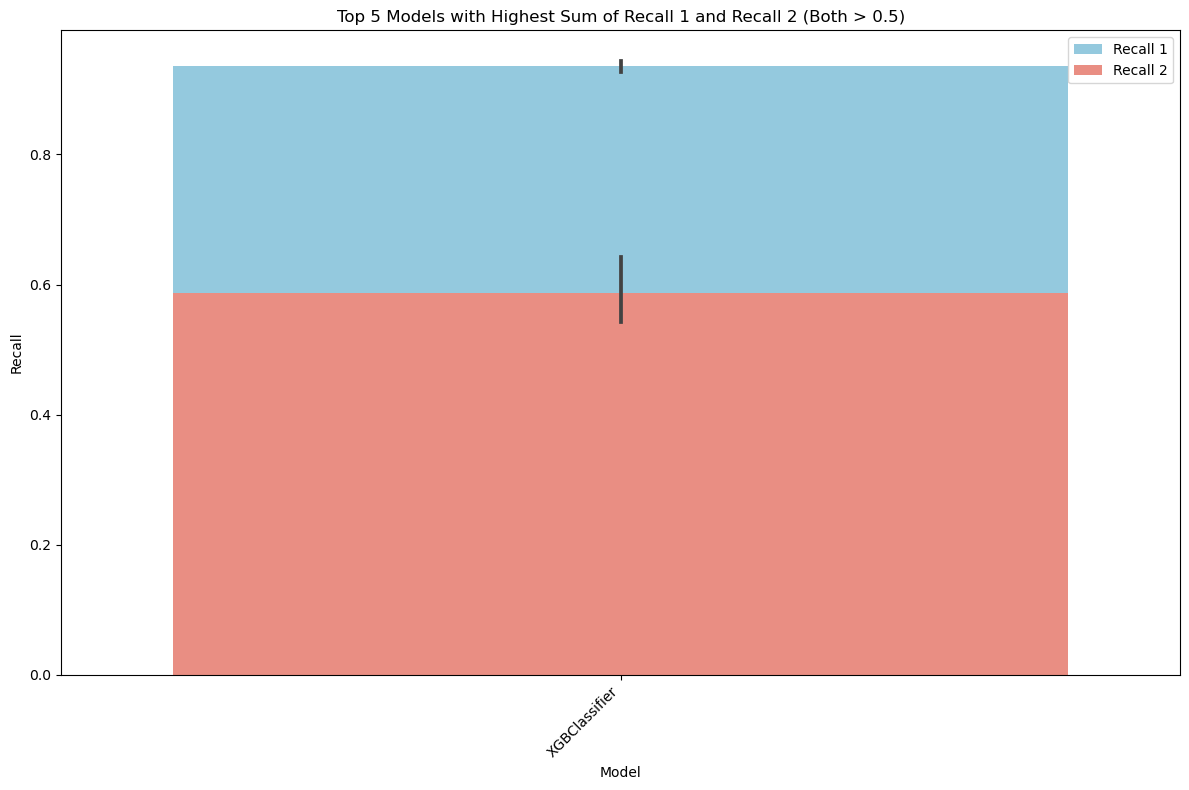

In [41]:
# Filter the DataFrame based on conditions
filtered_df = combined_metrics[(combined_metrics['recall_1'] + combined_metrics['recall_2'] > 0.5) & 
                               (combined_metrics['recall_1'] > 0.5) &
                               (combined_metrics['recall_2'] > 0.5)]

# Sort the DataFrame based on the sum of recall_1 and recall_2
sorted_df = filtered_df.sort_values(by=['recall_1', 'recall_2'], ascending=False)

# Take the top 5 entries
top_5 = sorted_df.head(5)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5, x='model', y='recall_1', color='skyblue', label='Recall 1')
sns.barplot(data=top_5, x='model', y='recall_2', color='salmon', label='Recall 2')
plt.title('Top 5 Models with Highest Sum of Recall 1 and Recall 2 (Both > 0.5)')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
# Filter the DataFrame based on conditions
filtered_df = combined_metrics[(combined_metrics['recall_1'] <= combined_metrics['recall_2']) & 
                               (combined_metrics['recall_1'] > 0.7) &
                               (combined_metrics['recall_2'] > 0.7)]

In [43]:
filtered_df

,dataset,model,data balancing technique,fold,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
20,DF5,XGBClassifier,Random Under Sampler,1,0.927273,0.555556,0.718310,0.862069,0.809524,0.675676,71.0,29.0,51,4,25,20
40,DF5,XGBClassifier,SMOTEENN,1,0.892308,0.553191,0.734177,0.787879,0.805556,0.650000,79.0,33.0,58,7,26,21
46,DF5,XGBClassifier,SMOTEENN,7,0.909091,0.511111,0.731707,0.793103,0.810811,0.621622,82.0,29.0,60,6,23,22
78,DF5c,XGBClassifier,Random Under Sampler,1,0.912281,0.558140,0.732394,0.827586,0.812500,0.666667,71.0,29.0,52,5,24,19
86,DF5c,XGBClassifier,Random Under Sampler,9,0.883333,0.450000,0.706667,0.720000,0.785185,0.553846,75.0,25.0,53,7,18,22


In [44]:
# Assuming you have a list of accuracy scores across folds
accuracy_scores = [0.85, 0.82, 0.88, 0.84, 0.87]

# Calculate the mean and standard deviation of accuracy scores
mean_accuracy = np.median(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.85
Standard Deviation of Accuracy: 0.02135415650406264


In [45]:
# Assuming combined_metrics is your DataFrame containing the mentioned columns
mean_metrics = filtered_df.groupby(['dataset', 'model', 'data balancing technique']).median().reset_index()

# Drop the 'fold' column as it's not needed for the mean calculation
mean_metrics.drop(columns=['fold','dataset'], inplace=True)

print(mean_metrics)

           model data balancing technique  precision_1  precision_2  recall_1  \
0  XGBClassifier     Random Under Sampler     0.927273     0.555556  0.718310   
1  XGBClassifier                 SMOTEENN     0.900699     0.532151  0.732942   
2  XGBClassifier     Random Under Sampler     0.897807     0.504070  0.719531   

   recall_2  f1-score_1  f1-score_2  support_1  support_2    TP   FP    TN  \
0  0.862069    0.809524    0.675676       71.0       29.0  51.0  4.0  25.0   
1  0.790491    0.808183    0.635811       80.5       31.0  59.0  6.5  24.5   
2  0.773793    0.798843    0.610256       73.0       27.0  52.5  6.0  21.0   

     FN  
0  20.0  
1  21.5  
2  20.5  


In [46]:
mean_metrics

,model,data balancing technique,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
0,XGBClassifier,Random Under Sampler,0.927273,0.555556,0.718310,0.862069,0.809524,0.675676,71.0,29.0,51.0,4.0,25.0,20.0
1,XGBClassifier,SMOTEENN,0.900699,0.532151,0.732942,0.790491,0.808183,0.635811,80.5,31.0,59.0,6.5,24.5,21.5
2,XGBClassifier,Random Under Sampler,0.897807,0.504070,0.719531,0.773793,0.798843,0.610256,73.0,27.0,52.5,6.0,21.0,20.5


In [47]:
# Assuming combined_metrics is your DataFrame containing the mentioned columns
std_metrics = filtered_df.groupby(['dataset', 'model', 'data balancing technique']).std().reset_index()

# Drop the 'fold' column as it's not needed for the mean calculation
std_metrics.drop(columns=['fold','dataset'], inplace=True)

print(std_metrics)

           model data balancing technique  precision_1  precision_2  recall_1  \
0  XGBClassifier     Random Under Sampler          NaN          NaN       NaN   
1  XGBClassifier                 SMOTEENN     0.011868     0.029755  0.001746   
2  XGBClassifier     Random Under Sampler     0.020469     0.076466  0.018192   

   recall_2  f1-score_1  f1-score_2  support_1  support_2        TP        FP  \
0       NaN         NaN         NaN        NaN        NaN       NaN       NaN   
1  0.003694    0.003716    0.020067   2.121320   2.828427  1.414214  0.707107   
2  0.076075    0.019314    0.079776   2.828427   2.828427  0.707107  1.414214   

         TN        FN  
0       NaN       NaN  
1  2.121320  0.707107  
2  4.242641  2.121320  


In [48]:
std_metrics

,model,data balancing technique,precision_1,precision_2,recall_1,recall_2,f1-score_1,f1-score_2,support_1,support_2,TP,FP,TN,FN
0,XGBClassifier,Random Under Sampler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XGBClassifier,SMOTEENN,0.011868,0.029755,0.001746,0.003694,0.003716,0.020067,2.121320,2.828427,1.414214,0.707107,2.121320,0.707107
2,XGBClassifier,Random Under Sampler,0.020469,0.076466,0.018192,0.076075,0.019314,0.079776,2.828427,2.828427,0.707107,1.414214,4.242641,2.121320
